# Bayesian inference for strike zone analysis

The logistic regression model used in [this notebook](https://www.kaggle.com/pschale/player-ejections-and-strike-zone-size?scriptVersionId=13002959) was trained using a simple scipy.minimize function. But this can't deal with smaller datasets well, and doesn't come with built-in error analysis. In this notebook, I'll fit that model with Bayesian statistics, and end by quantify the difference between a left-handed hitter's strike zone and a righty's. It may surprise most non-baseballs fans to learn that the strike zone isn't called the same way, but it's true: it's like the plate moves an inch and a half when a lefty comes up.

First we import the data, try to cut out clear outliers, and grab 10,000 random pitches.

In [1]:
import numpy as np 
import pandas as pd 
import pymc3 as pm
import seaborn as sns
import matplotlib.pyplot as plt
import theano.tensor as tt

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
pitches = pd.read_csv('../input/pitches.csv')
atbats = pd.read_csv('../input/atbats.csv', index_col='ab_id')
games = pd.read_csv('../input/games.csv', index_col='g_id')
ej = pd.read_csv('../input/ejections.csv')

In [3]:
pitches.dropna(inplace=True)
called_pitches = pitches[pitches.code.isin(['C', 'B'])].copy()
called_pitches['k'] = (called_pitches.code=='C').astype(int)
called_pitches = called_pitches[(called_pitches.k == 0) | 
                                ((np.abs(called_pitches.px) < 2) & (called_pitches.pz > 0.2) &
                                 (called_pitches.pz < 4.5))]

called_pitches = called_pitches.join(atbats, on='ab_id')
called_pitches['lefty'] = (called_pitches.stand == 'L')*1

balls_strikes_ejs = ej[~(ej['BS'].isna())].groupby('g_id').head(n=1)
balls_strikes_ejs = balls_strikes_ejs.set_index('g_id')
balls_strikes_ejs.rename(columns={'event_num': 'ej_event_num', 
                                  'ab_id': 'ej_ab_id'}, inplace=True)

ej_pitches = called_pitches[['pz', 'px', 'ab_id', 'code', 'k',
                             'event_num', 'top', 'g_id', 
                             'lefty', 'p_throws']].join(balls_strikes_ejs, how='right', on='g_id')
ej_pitches['d'] = ej_pitches.ej_event_num - ej_pitches.event_num
ej_pitches['after_ej'] = ej_pitches.d < 0
ej_pitches['ej_team_batting'] = ~(ej_pitches.top == ej_pitches.is_home_team)

In [4]:
X = ej_pitches[ej_pitches['ej_team_batting'] & ~ej_pitches['after_ej']][['px', 'pz', 'lefty', 'k']].dropna().values

# Building the model

This model is essentially the same one as in the prior notebook, but we must define it using PyMC3. Once it's defined, PyMC3 does everything by just calling .sample().

One complication with Bayesian statistics is that it requires priors. Here I've used fairly generous priors; with 10,000 data points those priors aren't extremely important. But if we tried to run on a single game, for example, the choice of priors would have a large impact on the output results.

In [5]:
edge_means = [-1, 1, 3.5, 1.5]
side_names = ['left', 'right', 'up', 'down']

with pm.Model() as model:
    
    edges = pm.Normal('edges', mu=edge_means, sd=0.2, shape=4)
    coefs = pm.TruncatedNormal('coefs', mu=10, sd=2, lower=1, shape=4)
    parabs = pm.Normal('parabs', mu=1, sd=1, shape=4)
    lefty_adj = pm.Normal('lefty_adj', mu=0, sd=0.1)
    mid_x = (edges[0] + edges[1])/2
    mid_y = (edges[2] + edges[3])/2
    
    def calc_strike_proba(data):
        xdata = data[:,0] + data[:,2]*lefty_adj
        left_logodds = (xdata - edges[0])*coefs[0] + ((data[:,1] - mid_y)**2)*parabs[0]
        right_logodds = - (xdata - edges[1])*coefs[1] - ((data[:,1] - mid_y)**2)*parabs[1]
        up_logodds = - (data[:, 1] - edges[2])*coefs[2] - ((xdata - mid_x)**2)*parabs[2]
        down_logodds = (data[:, 1] - edges[3])*coefs[3] + ((xdata - mid_x)**2)*parabs[3]

        logodds = [left_logodds, right_logodds, up_logodds, down_logodds]
        odds = [np.exp(lo) for lo in logodds]
        probs = [o/(o+1) for o in odds]
        out_proba = probs[0]*probs[1]*probs[2]*probs[3]
        return out_proba
    
    pitch_preds = calc_strike_proba(X)
    strike_proba = pm.Bernoulli('strike_proba', p=pitch_preds, observed=X[:,3])
    
    res=0.05
    xx, yy = np.meshgrid(np.arange(-1.5, 1.5, res),
                         np.arange(1, 4.5, res))
    grid_preds = calc_strike_proba(np.c_[xx.ravel(), yy.ravel(), xx.ravel()*0])
    zone_size = pm.Deterministic('size_of_zone', grid_preds.sum()*(res**2)*144)
    
    #incon_actual = pm.Deterministic('incon_actual', 
    #                                ((1 - pitch_preds)**X[:,3]) * 
    #                                        (pitch_preds**(1-X[:,3])))
    #incon_expected = pm.Deterministic('incon_expected', 
    #                                  ((1 - pitch_preds)**pitch_preds) * 
    #                                          (pitch_preds**(1-pitch_preds)))
    
    #incon_score = pm.Deterministic('incon_score', incon_actual - incon_expected)
    
    trace = pm.sample(1000, init='advi')

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 3,523.6:  14%|█▍        | 28192/200000 [06:14<38:27, 74.46it/s]
Convergence achieved at 28200
Interrupted at 28,199 [14%]: Average Loss = 5,232.7
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lefty_adj, parabs, coefs, edges]
Sampling 2 chains: 100%|██████████| 3000/3000 [04:01<00:00,  5.44draws/s]


## Now that the model's been sampled, we can just plot the posteriors and see the best-fit parameters, with built-in error bars

And this isn't just for the specific parameters of the model: notice that we told the model how to calculate the size of the strike zone given those parameters. PyMC3 automatically finds the posterior of this variable as well.

/opt/conda/lib/python3.6/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))


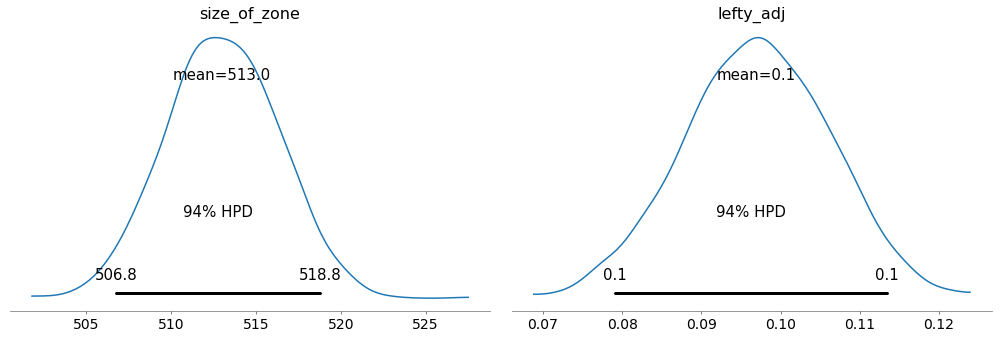

In [6]:
pm.plot_posterior(trace, ['size_of_zone', 'lefty_adj']);

So even though our prior on lefty_adjustment_(x) was a mean of 0 and standard deviation of 0.1, we can see a clear preference for a value of about 0.1 (in feet, so a bit over an inch). I've plotted all of the posteriors below

/opt/conda/lib/python3.6/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))


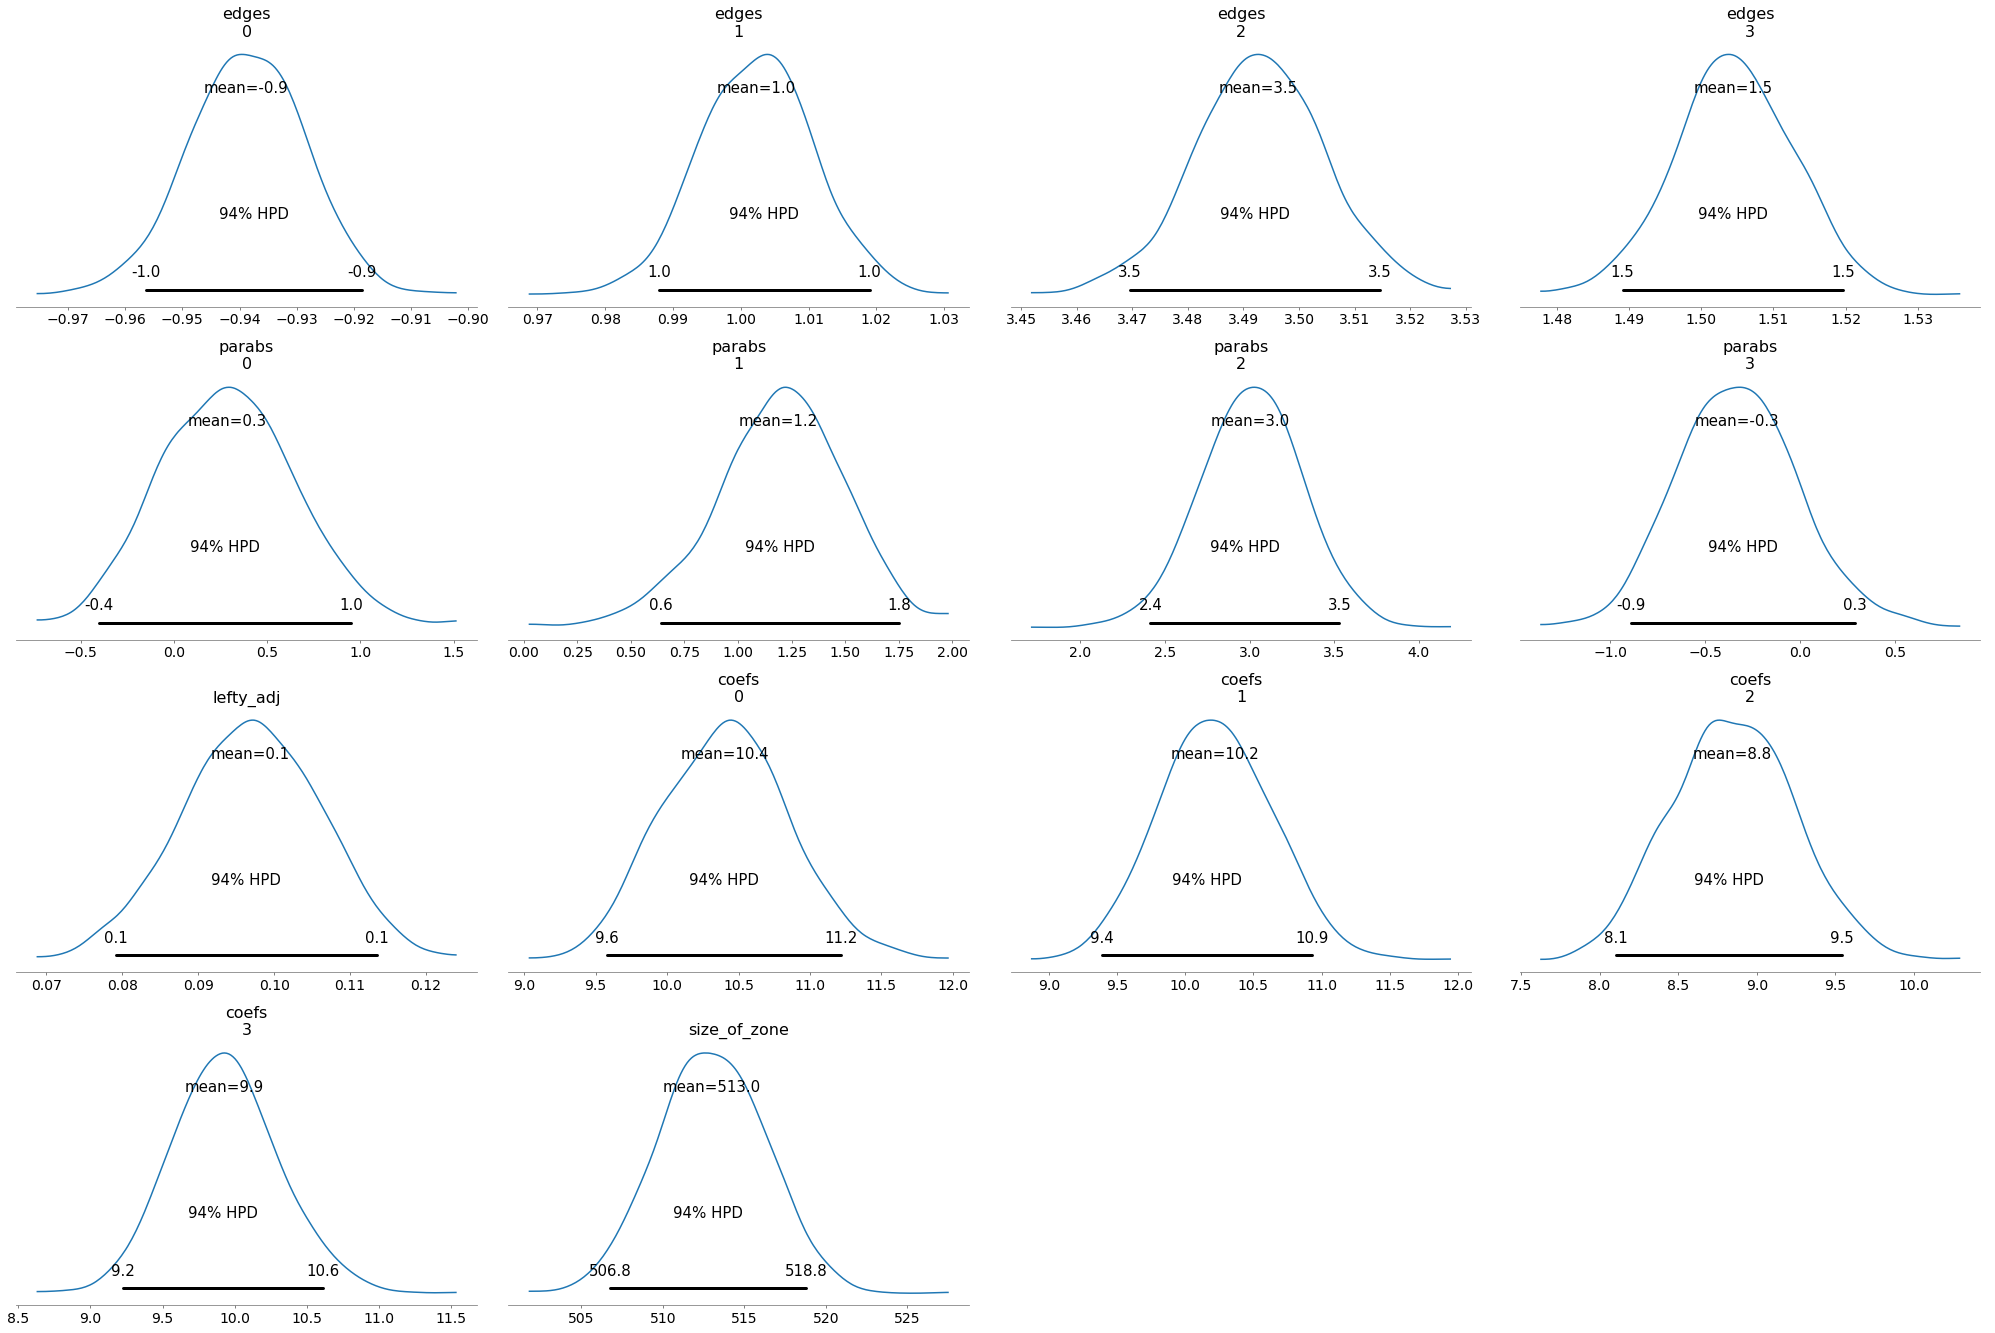

In [8]:
pm.plot_posterior(trace);

Finally, we can use this Bayesian framework to verify the trend found [using the simpler optimize method](https://www.kaggle.com/pschale/player-ejections-and-strike-zone-size?scriptVersionId=13002959): that the strike zone changes after ejections.

In [27]:
ej_pitches['group_num'] = 2*ej_pitches['ej_team_batting'] + ej_pitches['after_ej']
ej_pitches['prob_keep'] = ej_pitches['group_num']*0 + 0.1
ej_pitches.loc[(ej_pitches.pz > 1.3) & (ej_pitches.pz < 3.7) &
              (ej_pitches.px > -1.2) & (ej_pitches.px < 1.2), 'prob_keep'] = 1
ej_pitches.loc[(ej_pitches.pz > 1.7) & (ej_pitches.pz < 3.3) &
              (ej_pitches.px > -.8) & (ej_pitches.px < .8), 'prob_keep'] = 0.1
ej_pitches['kept'] = np.random.uniform(size=len(ej_pitches)) < ej_pitches.prob_keep

subsamp = ej_pitches[ej_pitches['kept']].dropna()
X = subsamp[['px', 'pz', 'lefty', 'k']].values
group_nums = subsamp['group_num'].values

18523


In [28]:
edge_means = [-1, 1, 3.5, 1.5]
side_names = ['left', 'right', 'up', 'down']
ngroups = 4

with pm.Model() as model:

    edges = pm.Normal('edges', mu=np.tile(edge_means, (ngroups,1)).T, sd=0.2, shape=(4, ngroups))
    coefs = pm.TruncatedNormal('coefs', mu=10, sd=2, lower=1, shape=(4, ngroups))
    parabs = pm.Normal('parabs', mu=1, sd=1, shape=(4, ngroups))
    lefty_adj = pm.Normal('lefty_adj', mu=0, sd=0.1, shape=ngroups)

    
    def calc_strike_proba(data, gn):
        mid_x = (edges[0][gn] + edges[1][gn])/2
        mid_y = (edges[2][gn] + edges[3][gn])/2
        xdata = data[:,0] + data[:,2]*lefty_adj[gn]
        
        left_logodds = (xdata - edges[0][gn])*coefs[0][gn] + ((data[:,1] - mid_y)**2)*parabs[0][gn]
        right_logodds = - (xdata - edges[1][gn])*coefs[1][gn] - ((data[:,1] - mid_y)**2)*parabs[1][gn]
        up_logodds = - (data[:, 1] - edges[2][gn])*coefs[2][gn] - ((xdata - mid_x)**2)*parabs[2][gn]
        down_logodds = (data[:, 1] - edges[3][gn])*coefs[3][gn] + ((xdata - mid_x)**2)*parabs[3][gn]

        logodds = [left_logodds, right_logodds, up_logodds, down_logodds]
        odds = [np.exp(lo) for lo in logodds]
        probs = [o/(o+1) for o in odds]
        out_proba = probs[0]*probs[1]*probs[2]*probs[3]
        return out_proba
    
    strike_proba = []
    for i in range(ngroups):
        Xg = subsamp.loc[subsamp.group_num==i, ['px', 'pz', 'lefty', 'k']].values
        pitch_preds = calc_strike_proba(Xg, i)
        strike_proba.append(pm.Bernoulli('strike_proba_group_' + str(i), p=pitch_preds, observed=Xg[:,3]))
    #pitch_preds = calc_strike_proba(X, group_nums)
    #strike_proba = pm.Bernoulli('strike_proba', p=pitch_preds, observed=X[:,3])
    
    res=0.05
    xx, yy = np.meshgrid(np.arange(-1.5, 1.5, res),
                         np.arange(1, 4.5, res))
    grid_preds_func = lambda x: calc_strike_proba(np.c_[xx.ravel(), yy.ravel(), xx.ravel()*0], (xx.ravel()*0 + x).astype(int))*(res**2)*144
    zone_preds = [grid_preds_func(i) for i in range(ngroups)]
    zonegray_by_group = [(4*ele*(1 - ele)).sum() for ele in zone_preds]
    zonesize_by_group = [ele.sum() for ele in zone_preds]
    #print(grid_preds([0,1])[0])
    #zone_size = pm.Deterministic('size_of_zone', tt.as_tensor_variable(grid_preds([0, 1])))
    zone_sizes = []
    zone_grays = []
    group_names = ['other_before', 'other_after', 'ejteam_before', 'ejteam_after']
    for i in range(ngroups):
        zone_sizes.append(pm.Deterministic('size_' + group_names[i], zonesize_by_group[i]))
        zone_grays.append(pm.Deterministic('gray_' + group_names[i], zonegray_by_group[i]))
        
    comparisons = [pm.Deterministic('comp_size_before', zonesize_by_group[2] - zonesize_by_group[0]),
                   pm.Deterministic('comp_size_after', zonesize_by_group[3] - zonesize_by_group[1]),
                   pm.Deterministic('comp_size_ejteam', zonesize_by_group[3] - zonesize_by_group[2]),
                   pm.Deterministic('comp_size_other', zonesize_by_group[1] - zonesize_by_group[0])]
    
    #incon_actual = pm.Deterministic('incon_actual', 
    #                                ((1 - pitch_preds)**X[:,3]) * 
    #                                        (pitch_preds**(1-X[:,3])))
    #incon_expected = pm.Deterministic('incon_expected', 
    #                                  ((1 - pitch_preds)**pitch_preds) * 
    #                                          (pitch_preds**(1-pitch_preds)))
    
    #incon_score = pm.Deterministic('incon_score', incon_actual - incon_expected)
    
    trace = pm.sample(1000, init='advi')

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 7,755.8:  15%|█▍        | 29294/200000 [08:21<48:54, 58.18it/s]
Convergence achieved at 29300
Interrupted at 29,299 [14%]: Average Loss = 9,529.6
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lefty_adj, parabs, coefs, edges]
Sampling 2 chains: 100%|██████████| 3000/3000 [11:18<00:00,  3.36draws/s]


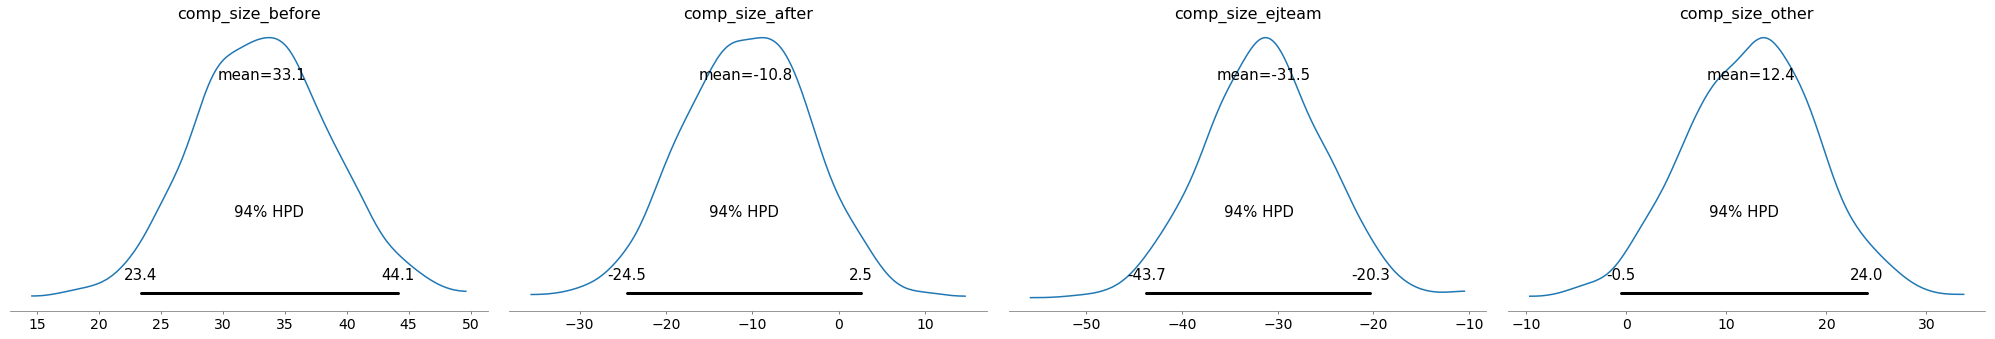

In [29]:
pm.plot_posterior(trace, ['comp_size_before', 'comp_size_after', 'comp_size_ejteam', 'comp_size_other']);

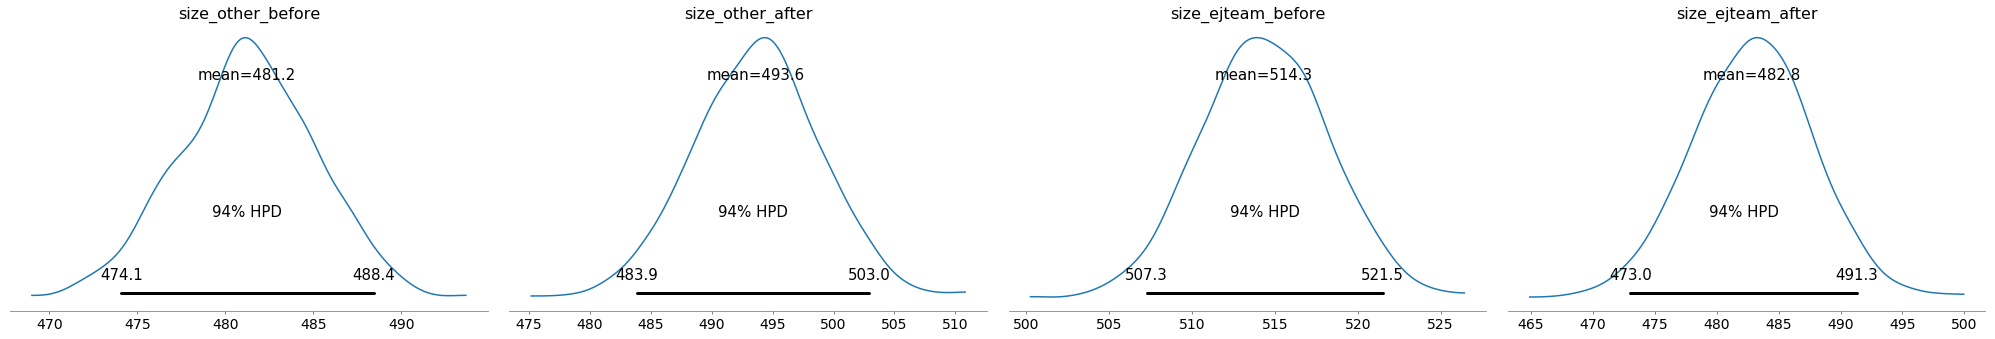

In [30]:
pm.plot_posterior(trace, ['size_other_before', 'size_other_after', 'size_ejteam_before', 'size_ejteam_after']);

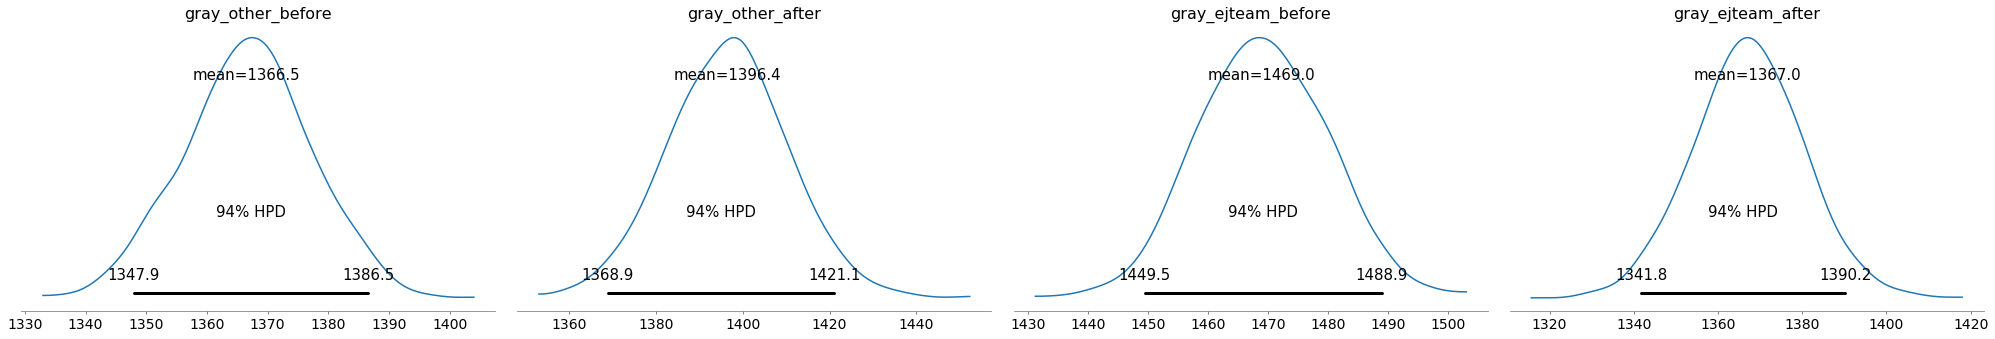

In [31]:
pm.plot_posterior(trace, ['gray_other_before', 'gray_other_after', 'gray_ejteam_before', 'gray_ejteam_after']);